In [58]:
import torch
import argparse
import numpy as np
import random
from DCN import DCN
from torchvision import datasets, transforms
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
parser = argparse.ArgumentParser(description='Deep Clustering Network')

# Dataset parameters
parser.add_argument('--dir', default='../Dataset/mnist',
                        help='dataset directory')
parser.add_argument('--input-dim', type=int, default=28*28,
                        help='input dimension')

# Autoenconder
parser.add_argument('--pretrained-model-path', type=str,
                        default='pretrained_autoencoder_mnist.pth',
                        help='Path to save/load the pre-trained autoencoder')

# Training parameters
parser.add_argument('--lr', type=float, default=0.002,
                        help='learning rate (default: 1e-4)')
parser.add_argument('--wd', type=float, default=5e-4,
                        help='weight decay (default: 5e-4)')
parser.add_argument('--batch-size', type=int, default=128,
                        help='input batch size for training')
parser.add_argument('--epoch', type=int, default=50,
                        help='number of epochs to train')
parser.add_argument('--pre-epoch', type=int, default=50,
                        help='number of pre-train epochs')

parser.add_argument('--pretrain', type=bool, default=True,
                        help='whether use pre-training')

parser.add_argument('--seed', type=int, default=24,
                        help='set the seed')

parser.add_argument('--train_proportion', type=float, default=0.8,
                        help='set the proportion of the training data')

# Model parameters
parser.add_argument('--lamda', type=float, default=0.005,
                        help='coefficient of the reconstruction loss')
parser.add_argument('--beta', type=float, default=1,
                        help='coefficient of the regularization term on ' \
                            'clustering')
parser.add_argument('--hidden-dims', default=[500, 500, 2000],
                        help='hidden dimensions')
parser.add_argument('--latent-dim', type=int, default=10,
                        help='latent space dimension')
parser.add_argument('--n-clusters', type=int, default=10,
                        help='number of clusters in the latent space')
parser.add_argument('--clustering', type=str, default='kmeans',
                        help='choose a clustering method (default: kmeans)' \
                       ' meanshift, tba')


# Utility parameters
parser.add_argument('--n-jobs', type=int, default=1,
                        help='number of jobs to run in parallel')
parser.add_argument('--device', type=str, default='cpu',
                        help='device for computation (default: cuda)')
parser.add_argument('--log-interval', type=int, default=400,
                        help='how many batches to wait before logging the ' \
                            'training status')
parser.add_argument('--test-run', action='store_true',
                        help='short test run on a few instances of the dataset')


# ✅ This allows the script to ignore unknown args (e.g., -f <file>)
args, unknown = parser.parse_known_args()

In [27]:
def evaluate(model, test_loader):
    y_test = []
    y_pred = []
    for data, target in test_loader:
        batch_size = data.size()[0]
        data = data.view(batch_size, -1).to(model.device)
        latent_X = model.autoencoder(data, latent=True)
        latent_X = latent_X.detach().cpu().numpy()

        y_test.append(target.view(-1, 1).numpy())
        y_pred.append(model.clustering.update_assign(latent_X).reshape(-1, 1))

    y_test = np.vstack(y_test).reshape(-1)
    y_pred = np.vstack(y_pred).reshape(-1)
    return (normalized_mutual_info_score(y_test, y_pred),
            adjusted_rand_score(y_test, y_pred))

def solver(args, model, train_loader, val_loader):

    rec_loss_list = model.pretrain(train_loader, epoch=args.pre_epoch)
    nmi_list = []
    ari_list = []

    for e in range(args.epoch):
        model.train()
        model.fit(e, train_loader)

        model.eval()
        NMI, ARI = evaluate(model, val_loader)  # evaluation on the test_loader
        nmi_list.append(NMI)
        ari_list.append(ARI)

        print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f}'.format(
            e+1, NMI, ARI))

    return rec_loss_list, nmi_list, ari_list


In [28]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

In [29]:
# Load data
transformer = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),
                                                           (0.3081,))])


train_set = datasets.MNIST(args.dir, train=True, download=True, transform=transformer)
test_set  = datasets.MNIST(args.dir, train=False, transform=transformer)

# print dataset shape
print('Train size: ', len(train_set), ' Test size: ', len(test_set))

Train size:  60000  Test size:  10000


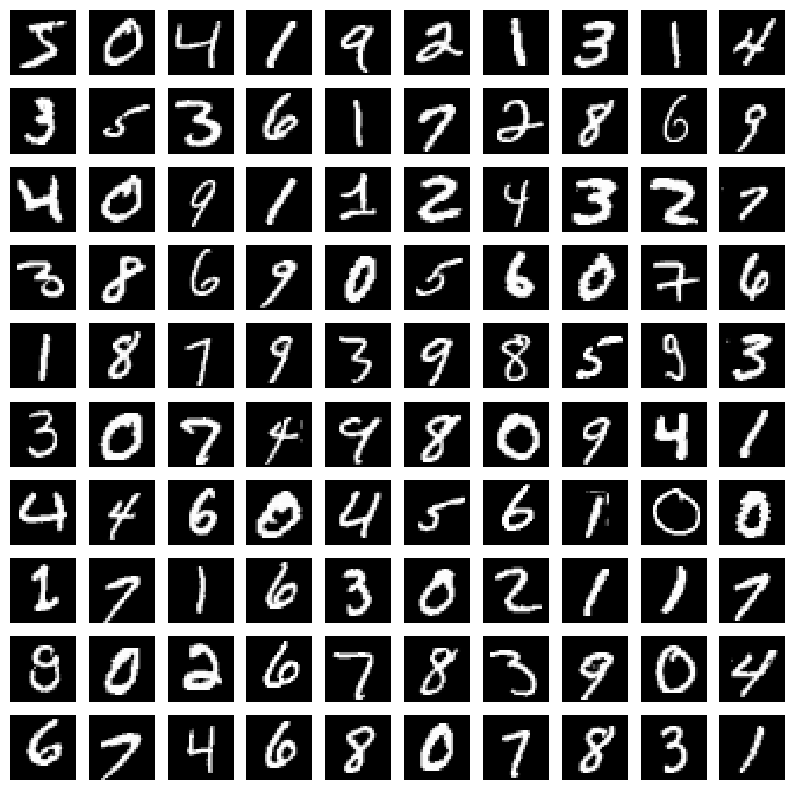

In [11]:
plt.figure(figsize=[10,10])
for i in range(0,100):
    plt.subplot(10,10,i+1)
    plt.imshow(np.reshape(train_set[i][0], (28,28)), interpolation='none',cmap=plt.get_cmap('gray'))
    plt.axis('off')

In [13]:
def partition_dataset(n, proportion=0.8):
  train_num = int(n * proportion)
  indices = np.random.permutation(n)
  train_indices, val_indices = indices[:train_num], indices[train_num:]
  return train_indices, val_indices

if args.train_proportion == 1.0:
  # we use all train dataset without partitioning
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=args.batch_size, shuffle=False)
  val_loader = test_loader
else:
  # partition dataset according to train_proportion
  train_indices, val_indices = partition_dataset(len(train_set), args.train_proportion)
  # create data loaders for train, validation and test datasets
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, sampler=SubsetRandomSampler(train_indices))
  val_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, sampler=SubsetRandomSampler(val_indices))
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=args.batch_size, shuffle=False)

In [76]:
print("latent-dim:", args.latent_dim)
print("Epochs:", args.epoch)
print("Pre-epochs:", args.pre_epoch)
print("Lambda:", args.lamda)
print("Learning rate:", args.lr)
print("Device:", args.device)

latent-dim: 10
Epochs: 50
Pre-epochs: 50
Lambda: 0.005
Learning rate: 0.002
Device: cpu


In [77]:
model = DCN(args)
rec_loss_list, nmi_list, ari_list = solver(
        args, model, train_loader, val_loader)

========== Start pretraining ==========
Epoch: 00 | Batch: 000 | Rec-Loss: 133394.062
Epoch: 01 | Batch: 000 | Rec-Loss: 25040.582
Epoch: 02 | Batch: 000 | Rec-Loss: 19816.301
Epoch: 03 | Batch: 000 | Rec-Loss: 18341.139
Epoch: 04 | Batch: 000 | Rec-Loss: 17108.561
Epoch: 05 | Batch: 000 | Rec-Loss: 17183.490
Epoch: 06 | Batch: 000 | Rec-Loss: 16803.566
Epoch: 07 | Batch: 000 | Rec-Loss: 15471.078
Epoch: 08 | Batch: 000 | Rec-Loss: 15767.250
Epoch: 09 | Batch: 000 | Rec-Loss: 16362.434
Epoch: 10 | Batch: 000 | Rec-Loss: 15179.655
Epoch: 11 | Batch: 000 | Rec-Loss: 14584.016
Epoch: 12 | Batch: 000 | Rec-Loss: 14975.881
Epoch: 13 | Batch: 000 | Rec-Loss: 14870.166
Epoch: 14 | Batch: 000 | Rec-Loss: 15188.887
Epoch: 15 | Batch: 000 | Rec-Loss: 14366.872
Epoch: 16 | Batch: 000 | Rec-Loss: 12951.580
Epoch: 17 | Batch: 000 | Rec-Loss: 13016.799
Epoch: 18 | Batch: 000 | Rec-Loss: 14235.480
Epoch: 19 | Batch: 000 | Rec-Loss: 13115.834
Epoch: 20 | Batch: 000 | Rec-Loss: 12570.258
Epoch: 21 | Ba

In [78]:
import os
# Create folder if not exists
os.makedirs("fig", exist_ok=True)
plt.style.use('seaborn-v0_8-whitegrid')

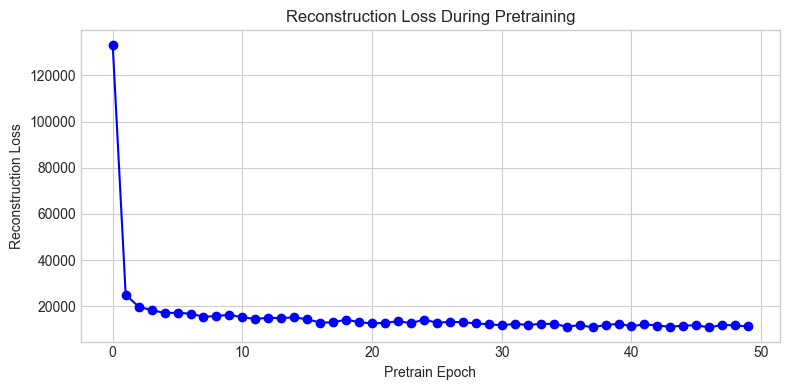

In [79]:
# Plot Rec-Loss during Pretraining
plt.figure(figsize=(8, 4))
plt.plot(rec_loss_list, marker='o', color='blue')
plt.title("Reconstruction Loss During Pretraining")
plt.xlabel("Pretrain Epoch")
plt.ylabel("Reconstruction Loss")
plt.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig("fig/loss_mnist.png")

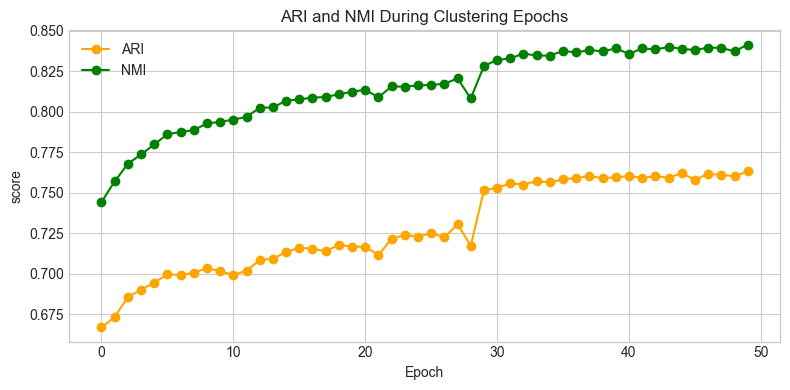

In [80]:
# Plot ARI and NMI
plt.figure(figsize=(8, 4))
plt.plot(ari_list, marker='o', label="ARI", color='orange')
plt.plot(nmi_list, marker='o', label="NMI", color='green')
plt.title("ARI and NMI During Clustering Epochs")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("score")
plt.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig("fig/ari_mnist.png")

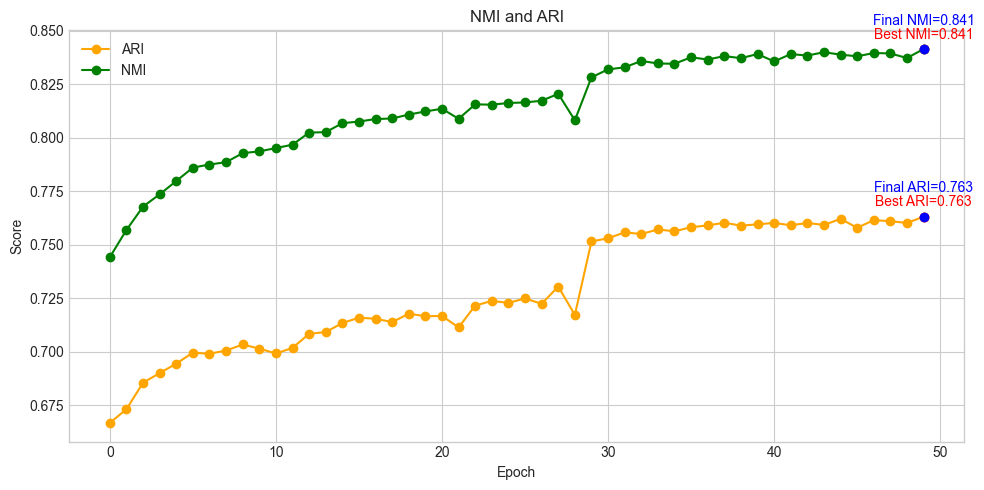

In [84]:
# Convert lists to numpy arrays
ari_array = np.array(ari_list)
nmi_array = np.array(nmi_list)

# Find best epoch based on ARI + NMI
combined_score = ari_array + nmi_array
best_epoch = np.argmax(combined_score)
best_ari = ari_array[best_epoch]
best_nmi = nmi_array[best_epoch]

# Get final values
final_epoch = len(ari_array) - 1
final_ari = ari_array[final_epoch]
final_nmi = nmi_array[final_epoch]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(ari_array, marker='o', label="ARI", color='orange')
plt.plot(nmi_array, marker='o', label="NMI", color='green')

# Highlight best combined performance (red)
plt.plot(best_epoch, best_ari, 'ro')
plt.plot(best_epoch, best_nmi, 'ro')
plt.text(best_epoch, best_ari + 0.01, f"Best ARI={best_ari:.3f}", color='red', ha='center', va="top")
plt.text(best_epoch, best_nmi + 0.01, f"Best NMI={best_nmi:.3f}", color='red', ha='center', va="top")

# Highlight final values (blue)
plt.plot(final_epoch, final_ari, 'bo')
plt.plot(final_epoch, final_nmi, 'bo')
plt.text(final_epoch, final_ari + 0.01, f"Final ARI={final_ari:.3f}", color='blue', ha='center', va="bottom")
plt.text(final_epoch, final_nmi + 0.01, f"Final NMI={final_nmi:.3f}", color='blue', ha='center', va="bottom")

# Labels and formatting
plt.title("NMI and ARI")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig("fig/ari_nmi_mnist.png")

In [86]:
nmi_test, ari_test = evaluate(model, test_loader)
print("NMI test:", nmi_test)
print("ARI test:", ari_test)

NMI test: 0.8421743079867914
ARI test: 0.757580195104925


In [92]:
from scipy.optimize import linear_sum_assignment
import numpy as np

def clustering_accuracy(y_true, y_pred):
    """Compute clustering accuracy using Hungarian algorithm"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    assert y_pred.size == y_true.size

    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)

    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(row_ind, col_ind)]) / y_pred.size

def evaluate_acc(model, test_loader):
    y_test = []
    y_pred = []

    for data, target in test_loader:
        batch_size = data.size(0)
        data = data.view(batch_size, -1).to(model.device)

        with torch.no_grad():
            latent_X = model.autoencoder(data, latent=True)
            latent_X = latent_X.detach().cpu().numpy()

        y_test.append(target.view(-1).numpy())
        y_pred.append(model.clustering.update_assign(latent_X))

    y_test = np.concatenate(y_test)
    y_pred = np.concatenate(y_pred)

    nmi = normalized_mutual_info_score(y_test, y_pred)
    ari = adjusted_rand_score(y_test, y_pred)
    acc = clustering_accuracy(y_test, y_pred)

    return nmi, ari, acc

In [93]:
nmi_test, ari_test, acc_test = evaluate_acc(model, test_loader)
print("NMI test:", nmi_test)
print("ARI test:", ari_test)
print("ACC test:", acc_test)

NMI test: 0.8421743079867914
ARI test: 0.757580195104925
ACC test: 0.8334


In [87]:
def extract_features( model, data_loader):
        """
        Extract latent features from the trained autoencoder.
        """
        model.eval()
        features = []
        labels = []
        with torch.no_grad():
            for data, target in data_loader:
                batch_size = data.size(0)
                data = data.to(model.device).view(batch_size, -1)
                latent = model.autoencoder(data, latent=True)
                features.append(latent.cpu().numpy())
                labels.append(target.cpu().numpy())
        return np.vstack(features), np.hstack(labels)

In [88]:
test_features, test_labels = extract_features(model, test_loader)

In [66]:
from sklearn.manifold import TSNE

In [89]:
# Run t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(test_features)

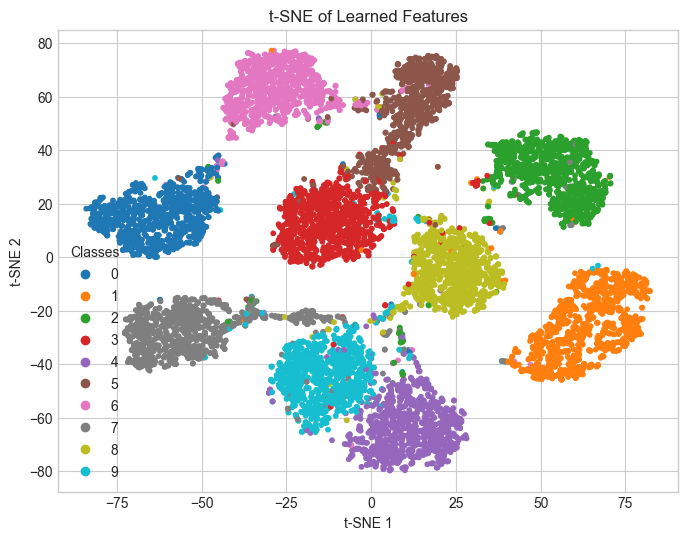

In [90]:
# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=test_labels, cmap='tab10', s=10)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("t-SNE of Learned Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()

In [91]:
torch.save(model.state_dict(), 'dcn_model.pth')

RUN KMEANS

In [100]:
# === Load your trained autoencoder ===
from autoencoder import AutoEncoder  # Your own module
autoencoder2 = model.autoencoder      # Make sure `args` is correctly set
# autoencoder2.__repr__()
# autoencoder2.load_state_dict(torch.load("pretrained_autoencoder_mnist.pth"))  # Optional
autoencoder2.eval().to('cpu')

[Structure]: 784-500-500-2000-10-2000-500-500-784
[n_layers]: 7
[n_clusters]: 10
[input_dims]: 784

In [101]:
all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1).to(autoencoder2.encoder[0].weight.device)  # Flatten if needed
        latent = autoencoder2(images, latent=True)
        all_features.append(latent.cpu().numpy())
        all_labels.append(labels.numpy())

features_ = np.vstack(all_features)
labels_ = np.concatenate(all_labels)

In [103]:
from sklearn.cluster import KMeans

kmeans_ = KMeans(n_clusters=10, n_init=20, random_state=42)
pred_labels_ = kmeans_.fit_predict(features_)

nmi_ = normalized_mutual_info_score(labels_, pred_labels_)
ari_ = adjusted_rand_score(labels_, pred_labels_)
acc_ = clustering_accuracy(labels_, pred_labels_)

print(f'Vanilla KMeans on MNIST -> NMI: {nmi_:.4f}, ARI: {ari_:.4f}, ACC: {acc_:.4f}')

Vanilla KMeans on MNIST -> NMI: 0.8411, ARI: 0.7669, ACC: 0.8337


In [106]:
from sklearn.datasets import fetch_openml

# 1. Load MNIST data (flattened to 784-dim vectors)
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype(np.float32)
y = mnist.target.astype(int)

In [108]:
from sklearn.preprocessing import StandardScaler

In [109]:
# 2. Optional: Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Apply KMeans directly on the raw data
kmeans2 = KMeans(n_clusters=10, random_state=42, n_init=20)
y_pred2 = kmeans2.fit_predict(X_scaled)

# 4. Evaluate with NMI and ARI
nmi2 = normalized_mutual_info_score(y, y_pred2)
ari2 = adjusted_rand_score(y, y_pred2)

print(f"NMI: {nmi2:.4f}")
print(f"ARI: {ari2:.4f}")

NMI: 0.4301
ARI: 0.3189
